In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../external_lib/Chexpert/')
sys.path.append('../../../external_lib/pytorch-grad-cam')

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from model import DRModel

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from einops import rearrange, reduce, repeat

from data.dataset import ImageDataset

from PIL import Image

import pandas as pd

In [9]:
# 查看torch版本
torch.__version__

'1.8.0'

In [10]:
# 查看表头信息
df = pd.read_csv('/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/train.csv')
df.columns

print('class 0:\t', df.columns[7])
print('class 1:\t', df.columns[10])
print('class 2:\t', df.columns[11])
print('class 3:\t', df.columns[13])
print('class 4:\t', df.columns[15])

class 0:	 Cardiomegaly
class 1:	 Edema
class 2:	 Consolidation
class 3:	 Atelectasis
class 4:	 Pleural Effusion


In [11]:
pretrained_file = '../checkpoints/epoch_0_0.8077.pth'
num_classes = 5
dr_model = DRModel(num_classes)
state_dict = torch.load(pretrained_file, map_location='cpu')
dr_model.load_state_dict(state_dict, strict=False)

target_layer = dr_model.features[7][-1]
cam = GradCAM(model=dr_model, target_layer=target_layer, use_cuda=True)

In [12]:
# dr_model.features[7][-1]

In [18]:
image_file = '/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg'

# # PIL image
# image = Image.open(image_file)
cv_img = cv2.imread(image_file)
cv_img = cv2.resize(cv_img, (512,512))
# print(image)


# normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# aug = torchvision.transforms.Compose([
#     transforms.Resize([512,512]),
#     transforms.ToTensor(),
#     normalize
# ])

# print(image)
# image = image.convert('RGB')
# print(image)
# input_tensor = aug(image)
# input_tensor = input_tensor.unsqueeze(0)


image = ImageDataset.aug(image_file)
image = image.numpy()
image = np.expand_dims(image, 0)
print(image.shape)
input_tensor = torch.from_numpy(image).cuda()


(1, 3, 512, 512)


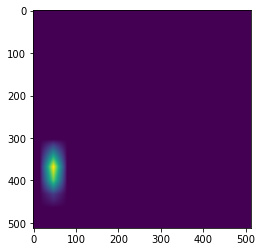

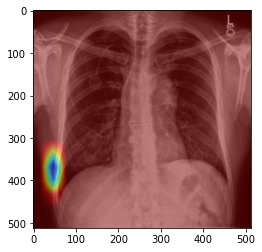

In [19]:
grayscale_cam = cam(input_tensor=input_tensor, target_category=2)

rgb_img = np.array(cv_img, np.float32)/255
visualization = show_cam_on_image(rgb_img, grayscale_cam)

plt.figure()
plt.imshow(grayscale_cam)
plt.figure()
plt.imshow(visualization)

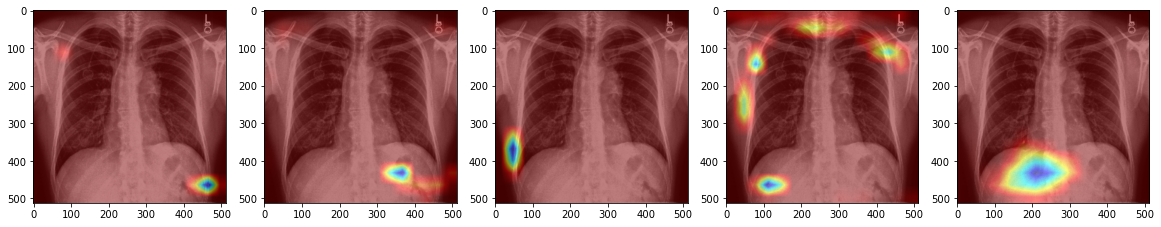

In [20]:
plt.figure(figsize=(20,10))
for num in range(num_classes):
    grayscale_cam = cam(input_tensor=input_tensor, target_category=num)
    rgb_img = np.array(cv_img, np.float32)/255
    visualization = show_cam_on_image(rgb_img, grayscale_cam)
    
    plt.subplot(1,num_classes,num+1)
    plt.imshow(visualization)

In [21]:
probs = dr_model(input_tensor.cuda())

In [22]:
class_names = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural_Effusion']
for i in range(num_classes):
    print('{} auc:\t{:.4f}'.format(class_names[i], probs.detach().cpu().numpy()[0][i]))

Cardiomegaly auc:	0.0370
Edema auc:	0.0096
Consolidation auc:	0.0814
Atelectasis auc:	0.1583
Pleural_Effusion auc:	0.2035
